# Logistic Regression and SGD Homework 
***
**Name**: $<$Rakesh Shivanand Margoor$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [242]:
import numpy as np
import matplotlib.pylab as plt
import collections
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [243]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        #print(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        #print(self.x)
        #print(self.nonzero)
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    #print(len(vocab))
    #print(vocab)
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    index = 0
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [554]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

Number of words in the vocabulary: 5327
Explain how the code is creating features (i.e. what text model is being used): Bag of words
1 = motorcycles and 0 = automobiles

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [610]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        self.iterationdict =collections.defaultdict(lambda:0)
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
       # print(train_example.x)
        # TODO implement LSR updates of weights 
        muiix = 0
        for w, x in zip(self.w, train_example.x):
            muiix += w * x
        
        muii = self.sigmoid(muiix) - train_example.y
        lsrmul = (1- 2*self.eta*self.lam)


        for ii in range(0, len(self.w)):
            if train_example.x[ii] != 0:
                self.w[ii] = self.w[ii] - (self.eta*(muii*train_example.x[ii]))
                if ii !=0:
                    self.w[ii] = self.w[ii] * (pow(lsrmul, (self.iterationdict[ii]) + 1))
                    self.iterationdict[ii] = 0
            else:
                self.iterationdict[ii] += 1
            
        
        

In [611]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.016s

OK


The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [612]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [560]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)



Update     0  TrnNLL  688.405  TstNLL   78.190  TrnA 0.698  TstA 0.702
Update     5  TrnNLL  905.698  TstNLL  106.518  TrnA 0.552  TstA 0.471
Update    10  TrnNLL  818.772  TstNLL   97.424  TrnA 0.578  TstA 0.545
Update    15  TrnNLL  966.793  TstNLL  108.249  TrnA 0.544  TstA 0.488
Update    20  TrnNLL  760.917  TstNLL   85.421  TrnA 0.624  TstA 0.628
Update    25  TrnNLL  551.120  TstNLL   62.694  TrnA 0.746  TstA 0.719
Update    30  TrnNLL  552.019  TstNLL   62.319  TrnA 0.765  TstA 0.752
Update    35  TrnNLL  526.411  TstNLL   59.644  TrnA 0.775  TstA 0.744
Update    40  TrnNLL  460.686  TstNLL   50.111  TrnA 0.816  TstA 0.810
Update    45  TrnNLL  459.168  TstNLL   48.443  TrnA 0.799  TstA 0.802
Update    50  TrnNLL  415.244  TstNLL   44.684  TrnA 0.819  TstA 0.843
Update    55  TrnNLL  408.459  TstNLL   43.888  TrnA 0.831  TstA 0.826
Update    60  TrnNLL  396.779  TstNLL   42.845  TrnA 0.835  TstA 0.826
Update    65  TrnNLL  384.545  TstNLL   42.522  TrnA 0.836  TstA 0.818
Update

Update   600  TrnNLL  121.927  TstNLL   29.034  TrnA 0.958  TstA 0.926
Update   605  TrnNLL  122.448  TstNLL   29.135  TrnA 0.958  TstA 0.926
Update   610  TrnNLL  124.221  TstNLL   29.631  TrnA 0.954  TstA 0.917
Update   615  TrnNLL  139.443  TstNLL   28.596  TrnA 0.956  TstA 0.917
Update   620  TrnNLL  191.461  TstNLL   32.745  TrnA 0.943  TstA 0.893
Update   625  TrnNLL  185.229  TstNLL   31.909  TrnA 0.947  TstA 0.909
Update   630  TrnNLL  182.750  TstNLL   30.806  TrnA 0.948  TstA 0.909
Update   635  TrnNLL  183.816  TstNLL   31.411  TrnA 0.948  TstA 0.909
Update   640  TrnNLL  186.747  TstNLL   33.244  TrnA 0.947  TstA 0.901
Update   645  TrnNLL  186.673  TstNLL   33.228  TrnA 0.947  TstA 0.901
Update   650  TrnNLL  175.775  TstNLL   30.309  TrnA 0.951  TstA 0.909
Update   655  TrnNLL  187.617  TstNLL   32.078  TrnA 0.947  TstA 0.893
Update   660  TrnNLL  174.548  TstNLL   29.788  TrnA 0.953  TstA 0.909
Update   665  TrnNLL  183.312  TstNLL   30.882  TrnA 0.951  TstA 0.909
Update

### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

[0.9421, 0.9339, 0.9587, 0.9752, 0.9339, 0.9091, 0.9174, 0.8926, 0.8678, 0.8843, 0.7851, 0.7107, 0.7355, 0.5041, 0.5702, 0.5785, 0.7438]


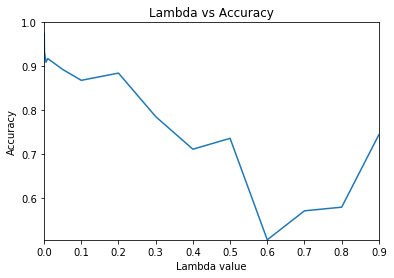

best lambda value 0.0005


In [561]:
lams = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy =[]
for lam in lams:
    lr = LogReg(train_set, test_set, lam, eta = 0.1)
    lr.train()
    NLL, acc = lr.compute_progress(test_set)
    accuracy.append(round(acc, 4))

print(accuracy)
plt.xlim(0, lams[-1])
plt.ylim(min(accuracy),1.0)
plt.xlabel("Lambda value")
plt.ylabel("Accuracy")
plt.title("Lambda vs Accuracy")
plt.plot(lams, accuracy)
plt.show()

bestlam = lams[accuracy.index(max(accuracy))]
print("best lambda value",bestlam)


**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

In [606]:
eta_vals = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
conv_threshold = 0.8
iterations =0
prevnll  = 0
prevprevnll =0
train_nll = 0
eta_iterations = {}


def Convergence(prevprevnll, prevnll, train_nll, conv_threshold):
    if(abs(prevnll - prevprevnll) < conv_threshold and abs(prevnll - train_nll) < conv_threshold ):
        return True
    else:
        return False
    
for eta in eta_vals:
    lr = LogReg(train_set, test_set, lam=0.5, eta = eta)
    i=0
    np.random.shuffle(lr.train_set)
    # loop over each training example

    for ex in lr.train_set:
        # perform SGD update of weights 
        lr.sgd_update(ex, iterations)
        prevprevnll = prevnll 
        prevnll = train_nll
        train_nll, train_acc = lr.compute_progress(lr.train_set)

        if(iterations > 3):
            if Convergence(prevprevnll, prevnll, train_nll, conv_threshold):
                i=11 #come out of loop
                eta_iterations[eta] = iterations
                iterations =0
                break
                    
        iterations += 1
print("eta_value vs eta_iterations", eta_iterations)


##################### Eta_val vs Accuracy################



Converged for 742.349891737 742.346644868 742.344353489
Converged for 742.332513119 742.321317324 742.34085585
Converged for 742.239599249 742.239163717 742.217602075
Converged for 742.155968713 741.625848109 741.594401351
Converged for 741.621440619 741.61725239 741.583891511
Converged for 730.476199943 729.797655696 729.460154231
Converged for 648.638495909 647.932891611 647.698667469
Converged for 591.329691891 591.261106421 591.702357999
Converged for 569.544590585 569.926386398 569.936547837
Converged for 761.626339544 760.877291595 760.394862749
Converged for 698.59913552 698.865981502 698.27309221
eta_value vs eta_iterations {1e-05: 4, 5e-05: 4, 0.0001: 4, 0.0005: 4, 0.001: 4, 0.005: 9, 0.01: 54, 0.05: 170, 0.1: 205, 0.3: 2085, 0.4: 588}


In the above, the convergence function is kind of approximate. If we optimize it and with a accurate threshold, the above code would show the difference of iterations with respect to changing eta values appropriately.

[0.9091, 0.9174, 0.9174, 0.9504, 0.9256, 0.9421, 0.9421, 0.9339, 0.9256, 0.9339, 0.9174, 0.9256, 0.8926, 0.8264, 0.9174, 0.9174, 0.8926]


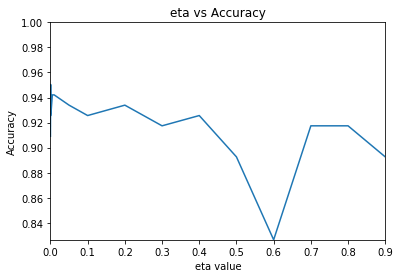

best eta value 0.0005


In [609]:
eta_vals = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy =[]
for eta in eta_vals:
    lr = LogReg(train_set, test_set, bestlam, eta)
    lr.train()
    NLL, acc = lr.compute_progress(test_set)
    accuracy.append(round(acc, 4))

print(accuracy)
plt.xlim(0, eta_vals[-1])
plt.ylim(min(accuracy),1.0)
plt.xlabel("eta value")
plt.ylabel("Accuracy")
plt.title("eta vs Accuracy")
plt.plot(eta_vals, accuracy)
plt.show()

besteta = eta_vals[accuracy.index(max(accuracy))]
print("best eta value",besteta)

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

I think, the words with higher value of weights would have higher impact to class 1. Hence, those would be the best predictors due to higher impact. In order to get the top 10 words, we have to find the words with top 10 larger weights. Similarly the 10 best predictors for class 0 would be the words with lowest 10 weights.

In [549]:
lr = LogReg(train_set, test_set, 0.01, 0.5)
lr.train()
best_positive_class_predictors =[]
best_negative_class_predictors = []
weights = list(lr.w)
descendingweights = sorted(weights, reverse=True)
ascendingweights = sorted(weights)
toptenWeights = descendingweights[:10]
lowesttenweights = ascendingweights[:10]

for weight in toptenWeights:
    best_positive_class_predictors.append(vocab[weights.index(weight)])
    
for weight in lowesttenweights:
    best_negative_class_predictors.append(vocab[weights.index(weight)])
    
print("Best predictors for motorcycle", best_positive_class_predictors)
print("Best predictors for automobiless", best_negative_class_predictors)

Best predictors for motorcycle ['bike', 'like', 'deductible', 'bikes', 'ca', 'ticket', 'berkeley', 'tire', 'mil', 'old']
Best predictors for automobiless ['side', 'clothing', 'cars', 'left', 'reply', 'hp', 'day', 'sweden', 'dallas', 'les']


**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

Same concept applies here, the worst predictors for class have values which are in the middle of the sorted weights, As they can be predicted as class 0 or 1. Hence, once we sort the weighted values, the center values are the ones which are worst predictor.


In [552]:
mid = int(len(ascendingweights)/2)
worst_positive_class_predictors = []
worst_negative_class_predictors = []

worstnegativeweights = ascendingweights[mid - 10:mid]
worstpositiveweights = ascendingweights[mid :mid + 10]

for weight in worstpositiveweights:
    worst_positive_class_predictors.append(vocab[weights.index(weight)])
    
for weight in worstnegativeweights:
    worst_negative_class_predictors.append(vocab[weights.index(weight)])
    
print("Worst predictors for motorcycle", worst_positive_class_predictors)
print("Worst predictors for automobiless", worst_negative_class_predictors)

Worst predictors for motorcycle ['tolerable', 'hired', 'becomes', 'tuesday', 'camber', 'sizes', 'corvettes', 'driveways', 'expenses', 'towing']
Worst predictors for automobiless ['probes', 'reads', 'swap', 'winters', 'qualities', 'grip', 'aiming', 'underside', 'eagles', 'goodyear']
